In [1]:
pwd

u'/Users/lampochka/Desktop/GitHub/Spencermodel'

In [2]:
from neuron import h, gui
from scipy import integrate
import numpy as np
%pylab inline
style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [3]:
h.load_file("Spencer.hoc")

1.0

In [4]:
from collections import defaultdict

In [5]:
# Посчитатель всех токов:

def net_dendrite_currents():
    "Total dendrite currents in nA"
    net_i = defaultdict(lambda: 0)

    for i in range(int(h.Nseg)):
        dend = h.dend[i]
        for loc in dend:
            a = loc.area()*1e-8*1e6 #конвертируем площадь в см^2 и ток в nA заодно
            net_i['ik'] += loc.ik*a 
            net_i['ih'] += loc.hcno.ih*a
            net_i['ileak'] += loc.i_leak*a
    return net_i

def net_soma_currents():
    net_i = defaultdict(lambda: 0)
    loc = h.soma(0.5)
    a = loc.area()*1e-8*1e6 #конвертируем площадь в см^2 и ток в nA заодно
    net_i['ik'] += loc.ik*a # все К токи
    try:
        net_i['ina'] += loc.nas.ina*a
    except NameError:
        print 'skipping iNa'
        
    #net_i['ih'] += loc.hs.ih*a
    net_i['ih'] += loc.hcno.i*a
    net_i['ileak'] += loc.i_leak*a
    return net_i

def net_axon_currents():
    net_i = defaultdict(lambda: 0)
    for comp in (h.initial, h.axon):
        for loc in comp:
            a = loc.area()*1e-8*1e6 #конвертируем площадь в см^2 и ток в nA заодно
            #net_i['ik'] += loc.ik*a # все К токи
            #net_i['ih'] += loc.ihsab.ih*a
            #net_i['ih'] += loc.hcno.ih*a
            net_i['ileak'] += loc.i_leak*a
            net_i['ina'] += loc.nas.ina*a
    return net_i

In [6]:
# %%writefile Energy_counter.py
# TODO: во все компартменты добавить *все* токи, только ненужные токи "выключить",
#       выставив gbar=0


# Посчитатель энергии в покое: (а) Способом Moujahid et al., 2011,
#(б) Способом подсчета ионов Attwell & Laughlin 2001

# (а)

def net_section_currendenrg(section):
    "Sum up specific currents within section and return in nA"
    net_i = defaultdict(lambda: 0)
    "e_acc holds resting energies"
    e_acc = defaultdict(lambda: 0)
    Erevs = {'ina':h.initial.ena,
             'ik':h.soma.ek,
             'ih':h.soma.eh_hcno,
             'leak': h.soma.erev_leak
            }
    for seg in section:
        a = seg.area()*1e-8*1e6 # конвертируем площадь в см^2 и ток в nA заодно
        
        try: 
            net_i['ik'] += seg.ik*a # все К токи: Iklt, Ikht. nA
            e_acc['ik'] += seg.ik*a*(seg.v-Erevs['ik']) # nA*mV = pW = 1e-12*W = 1e-12*J/s
        except NameError: 
            print "Skipping iK"
    
        try: 
            net_i['ina'] += seg.ina*a 
            e_acc['ina'] += seg.ina*a*(seg.v-Erevs['ina'])
        except NameError: 
            print "Skipping iNa"
            
        try: 
            net_i['ih'] += seg.hcno.i*a 
            e_acc['ih'] += seg.hcno.i*a*(seg.v-Erevs['ih'])
        except NameError: 
            print "Skipping ih"
            
        try: 
            net_i['leak'] += seg.leak.i*a 
            e_acc['leak'] += seg.leak.i*a*(seg.v-Erevs['leak'])
        except NameError: 
            print "Skipping leak"  
    return net_i, e_acc

# (б)

def net_section_AtLau_enrg(section) :
    "Counts total resting energy consumption in ATP_moles/s (CHECK THIS in AL&Lau2001)"
    
    F = 96450 # Кл/млоь
    Rin = 15.8e6 # значение Rin из литературы, octopus nrn (для кота Bal & Baydas 2009), Ом
    Fatp = 50*1e15 # энергия гидролиза АТФ в пДж/моль, по Moujahid et al., 2014 (п. 2.3)
    
#     Что делать с входным сопротивлением? По авторам формулы, Rin = 1/(gna+gk). 
#     Можно посчитать Rin в модели, но будет ли оно соответствовать формуле
#     Или: Какие брать значения gna, gk?
#     Вот, попробовал 6 МОм
  
    Erevs = {'ina':h.initial.ena,
             'ik':h.soma.ek,
             'ih':h.soma.eh_hcno,
             'leak': h.soma.erev_leak
            }
    J = ((Erevs['ina']-section.v)*(section.v-Erevs['ik'])*1e-3)/(F*Rin*(section.v+2*Erevs['ina']-3*Erevs['ik']))
        # J в моль_АТФ/
        
#     return  ("pmol_ATP/s at rest --> %.3e" % (J*1e12))
    return  J*1e12 #  pmol_ATP/s
#     return  ( "Energy in pJ/s %.6g" % (J*Fatp))

In [7]:
# Равновесная энергия сомы по Attwell & Laughlin 2001
# пДж/с

def total_e(sec):
    rATP = 0
    for seg in sec:
        rATP += net_section_AtLau_enrg(seg)
    return rATP


# de = net_section_AtLau_enrg(h.dend[1])
# se = net_section_AtLau_enrg(h.soma)
# ie = net_section_AtLau_enrg(h.initial)

# # curs = ['ik','ina', 'ileak', 'ih']

# print de,"\n", se,"\n", ie


In [8]:
all_sections = [h.soma, h.axon, h.initial,] + [h.dend[i] for i in range(4)]

a=0
for sec in all_sections:
    a += total_e(sec)
print a

0.937492270642


In [9]:
total_e(all_sections)

0.02031716995199091

In [12]:
# Равновесные токи и энергия сомы по Moujahid et al., 2011
# Единицы измерения: ток в нА, энергия в пДж/с
net_section_currendenrg(h.soma)

(defaultdict(<function __main__.<lambda>>,
             {'ih': -0.9781153272027189,
              'ik': 0.5957537671387584,
              'ina': 0.0,
              'leak': 0.07853981633974483}),
 defaultdict(<function __main__.<lambda>>,
             {'ih': 21.518537198459814,
              'ik': 5.957537671387584,
              'ina': 0.0,
              'leak': 0.15707963267948966}))

In [18]:
total = map(net_section_currendenrg, all_sections)

In [19]:
total[0][1].keys()

['ih', 'ik', 'ina', 'leak']

In [20]:
total[0][0].get('ih')


-0.9292623962492089

##### Измерить Rin, построить IV-характеристику

In [13]:
def Find_Rin(amps):
    V = []
    Rin = []
    h.tstop = 2000
    vrest = -59.651 # h.soma.v, after run with tstop = 2000.
    for i in amps:
        h.stm1(i,2000,320) # i, current in nanoAmps.
        V.append(h.soma.v)
        Rin.append((h.soma.v-vrest)*1e-3*1e-6/(i*1e-9)) # Ohm
        
    iv = figure(figsize=(10,6))
    ax = iv.add_subplot(111)
    iv.subplots_adjust(top = 0.85)   
    ax.set_title('IV curve')
    ax.set_xlabel('Iap, nA')
    ax.set_ylabel('V$_\infty$, mV')
#     ax.axis([290, 500, mi, ma])
    ax.plot(amps, V)
#     ax.legend(('$Proximal$', '$Distal$'))
    return np.mean(Rin), iv
    

(1.997010264958567, <matplotlib.figure.Figure at 0x10ea83c90>)

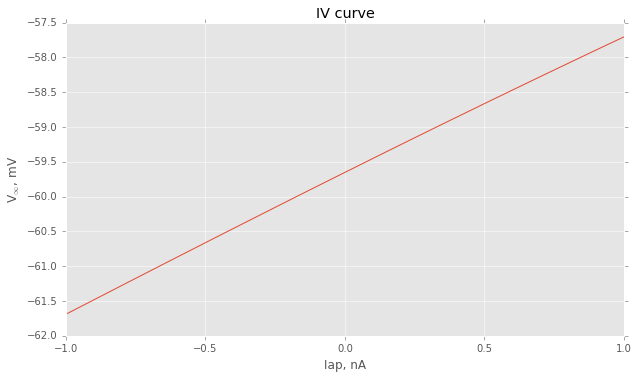

In [15]:
# IV-характеристика
amps =  [-1.0,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
Find_Rin(amps)

###### По вольт-амперной характеристике выходит, Rin = 2 MOhm (среднее)

In [16]:
# Уравновесим всё:
h.run()

0.0

In [17]:
h.soma(.5).ik == h.soma(.5).ik_kltoz + h.soma(.5).ik_khtoz

True

In [7]:
# Quick links to sections. 
sm = h.soma(.5)
dn = h.dend[1]
ax = h.axon(.5)
init = h.initial(.5)

In [19]:
# Note, dn takes (.5) location if not given
dn(.5).ik_kltoz == dn.ik_kltoz

True

In [8]:
# Определим Rin по проводимостям

def Rinis(seg, Rin_from_literature=0):
    gnar = seg.ina/(seg.v-seg.ena)  # Siemens/cm^2
    gkr = seg.ik/(seg.v-seg.ek)
    ghr = seg.i_hcno/(seg.v-seg.eh_hcno)
    glkr = seg.i_leak/(seg.v-seg.erev_leak)

#     Rin_o = 6.7 # MOhm, Bal & Oertel, 2001 (mice); 15.8 MOhm, Bal & Baydas, 2009 (cat)
    # From model:
    Ginx = (gnar + gkr + ghr + glkr)* seg.area()*1e-8
    Rin_ox = 1e-6/Ginx

#     print Rin_from_literature, 'in cit., in model:', Rin_ox, 'MOhm'
    return Rin_ox

In [9]:
# СЕКЦИИ СЕКЦИИ СЕКЦИИ СЕКЦИИ СЕКЦИИ СЕКЦИИ СЕКЦИИ СЕКЦИИ СЕКЦИИ СЕКЦИИ СЕКЦИИ СЕКЦИИ СЕКЦИИ СЕКЦИИ
sections = [sm, dn(.5), ax, init]

for i in sections:
    print Rinis(i, 6.7)

6.97812005303
1273.81591874
176.838825658
528.9406895


1274 MOhm.... 

# Определение затрат по Attwell, Moujahid, Hasegawa

In [10]:
R = 8314.4  # Universal gaz constant, mJ / mole*K
F = 96485   # Faraday constant [C/mol]
F_ATP = 50 # kJ/mol

avogadro = 6.022e23 # N_a

----------- A t t w e l l -----------

In [11]:
# Оценка по Attwell & Laughlin 2001
def e_attwell(seg, Rin):
    J_ATP = (seg.ena-seg.v)*(seg.v-seg.ek)/(F*Rin*(seg.v+2*seg.ena-3*seg.ek)) # nmol_ATP/s
    return J_ATP*1e3 # pmol/s

In [12]:
# Функции перевода единиц Дж <-> моль
def pmol2molecules(x):
    return x*1e-12*avogadro

def atp2J(nATP):
    "Convert pmol ATP/s to energy usage in pJoule/s"
    return F_ATP * nATP * 1e3
    pas

def nJ2atp(nJ):
    "convert from nJoule/s to nmol ATP/s"
    return (nJ/F_ATP)*1e-3

----------- M o u j a h i d / H a s e g a w a -----------

In [13]:
# Разделитель тока *Ih* на K- и Na- составляющие.
# gratio = gk/gna
def Ih_split(section, gratio=5):
    v = section.v    
    gnah = section.i_hcno/((gratio+1)*v - gratio*section.ek - section.ena)
    inah = gnah*(v-section.ena)
    ikh = gratio*gnah*(v-section.ek)
    return inah, ikh

# Разделитель тока I_leak на K- и Na- составляющие.
# gratio = gk/gna
def Ileak_split(section, gratio=1):
    v = section.v
    gnalk = section.i_leak/((gratio+1)*v - gratio*section.ek - section.ena)
    inalk = gnalk*(v-section.ena)
    iklk = gratio*gnalk*(v-section.ek)
    return inalk, iklk

In [14]:
# Оценка по Moujahid et al., 2011 
def e_moujahid_2(seg, Iap=0):
    v = seg.v
    inah, ikh = Ih_split(seg) # раскладываем ток Ih
    ina = seg.ina + inah # полный Na ток
    ik = seg.ik + ikh # полный K ток
    acc = Iap*v
    acc += ina*(v-seg.ena)
    acc += ik*(v-seg.ek)
    acc += seg.i_leak*(v-seg.erev_leak)
    factor = 1e-8*1e6 # um2 -> cm2 plus uJ/s -> pJ/s
    return acc*seg.area()*factor

# Оценка по Hasegawa, 2011
def e_hasegawa_2(seg, Iap=0):
    v = seg.v
    inah, ikh = Ih_split(seg) # раскладываем ток Ih
    ina = seg.ina + inah # полный Na ток
    ik = seg.ik + ikh # полный K ток
    acc = Iap*v
    acc -= ina*seg.ena
    acc -= ik*seg.ek
    acc -= seg.i_leak*seg.erev_leak
    factor = 1e-8*1e6 # um2 -> cm2 plus uJ/s -> pJ/s
    return acc*seg.area()*factor

In [16]:
h.run()
# Attwell
dH_sm_a =  atp2J(e_attwell(sm, Rinis(sm)))
dH_dn_a =  atp2J(e_attwell(dn(.5), Rinis(dn(.5)))) # Можно ли тут использовать Rinis(dn(.5)) = 1300???Вообще
dH_ax_a =  atp2J(e_attwell(ax, Rinis(ax)))
dH_init_a =  atp2J(e_attwell(init, Rinis(init)))
dH_sum_a = dH_sm_a+dH_ax_a+4*dH_dn_a+dH_init_a

# Moujahid
dH_sm_m =     e_moujahid_2(sm)
dH_dn_m =     e_moujahid_2(dn(.5))
dH_ax_m =     e_moujahid_2(ax)
dH_init_m =   e_moujahid_2(init)
dH_sum_m =    dH_sm_m+dH_ax_m+4*dH_dn_m+dH_init_m

# Hasegawa
dH_sm_h =     e_hasegawa_2(sm)
dH_dn_h =     e_hasegawa_2(dn(.5))
dH_ax_h =     e_hasegawa_2(ax)
dH_init_h =   e_hasegawa_2(init)
dH_sum_h =    dH_sm_h+dH_ax_h+4*dH_dn_h+dH_init_h


In [17]:
print\
"""Затраты в распределенной модели по Attwell (nJ/s) :
    soma:       {:.3e}
    dend[1]:    {:.3e}
    axon:       {:.3e}
    initial:    {:.3e}
---------------------------
    sum:        {:.3e}""".format(dH_sm_a, dH_dn_a, dH_ax_a, dH_init_a, dH_sum_a)

Затраты в распределенной модели по Attwell (nJ/s) :
    soma:       3.414e+02
    dend[1]:    1.765e+00
    axon:       1.332e+01
    initial:    4.451e+00
---------------------------
    sum:        3.662e+02


In [18]:
print\
"""Затраты в распределенной модели по Moujahid (nJ/s) :
    soma:       {:.3e}
    dend[1]:    {:.3e}
    axon:       {:.3e}
    initial:    {:.3e}
---------------------------
    sum:        {:.3e}""".format(dH_sm_m, dH_dn_m, dH_ax_m, dH_init_m, dH_sum_m)

Затраты в распределенной модели по Moujahid (nJ/s) :
    soma:       2.090e+02
    dend[1]:    2.859e-01
    axon:       3.027e-02
    initial:    1.006e-01
---------------------------
    sum:        2.103e+02


In [19]:
print\
"""Затраты в распределенной модели по Hasegawa (nJ/s) :
    soma:       {:.3e}
    dend[1]:    {:.3e}
    axon:       {:.3e}
    initial:    {:.3e}
---------------------------
    sum:        {:.3e}""".format(dH_sm_h, dH_dn_h, dH_ax_h, dH_init_h, dH_sum_h)

Затраты в распределенной модели по Hasegawa (nJ/s) :
    soma:       1.976e+02
    dend[1]:    3.146e-01
    axon:       8.111e-01
    initial:    3.126e-01
---------------------------
    sum:        1.999e+02


In [20]:
print\
"""Сравнение суммарных затрат энергии в распределенной модели,
рассчитанных по Attwell, Moujahid, Hasegawa (pJ/s) :

    Attwell & Laughlin, 2001:    {:.3e}
    Moujahid & D'Anjou, 2011:    {:.3e}
    Hasegawa, 2011:              {:.3e}""".format( dH_sum_a, dH_sum_m, dH_sum_h)

Сравнение суммарных затрат энергии в распределенной модели,
рассчитанных по Attwell, Moujahid, Hasegawa (pJ/s) :

    Attwell & Laughlin, 2001:    3.662e+02
    Moujahid & D'Anjou, 2011:    2.103e+02
    Hasegawa, 2011:              1.999e+02


In [21]:
# Отношение затрат Атвела к затратам Муджахида
print dH_sum_a/dH_sum_m

1.74185967947


### А какие значения получили Attwell & Laughlin 2001 и Howarth et al, 2012 для кортикальных нейронов в покое?


###### Attwell: 3.42*10^8 ATPs/s

In [22]:
E_atw_ratp = 3.42*1e8 #ATPs/s at rest
E_atw_pJ = atp2J((E_atw_ratp/avogadro)*1e12)
print E_atw_pJ

28.3958817669


In [23]:
# Во сколько раз octopus тратит больше, чем кортикальный нейрон ?
print dH_sm_a/E_atw_pJ

12.0235544246


###### Howarth: 15% от полных затрат (включая домашнее хозяйство) 27.2 umolATP/g/min

In [24]:
E_how = 0.15*27.2*1e-3/60 #molATP/g/s
rho_cort = 9.2*1e7 # neurons/g of neocortex (Braitenberg and Schüz, 1998), from Attwell & Laughlin 2001
E_how_pJ = atp2J(E_how*1e12/rho_cort)
print E_how_pJ

36956.5217391


# Потребление при активации

In [30]:
# Ключи к секциям.
dn
smm = h.soma
axx = h.axon
initt = h.initial
h.tstop = 5000

In [31]:
# Берет сегмент (для секций, разделенных на сегменты;
# для монолитных секций достаточно указать название секции),
# возвращает название сегмента в str.
def seg2str(seg):
    name = seg.sec.name()
    x = seg.x
    return '-'.join((name, '%1.2f'%x))

In [32]:
# Берет секцию и создает для нее список названий сегментов (list of strs).
def seglist(section):
    seglist = []
    for seg in section:
        seglist.append(seg2str(seg))
    return seglist

In [33]:
# Берет секцию и записывает для каждого ее сегмента 
# в отдельный словарь Vm, ik, ina, ihcno. Так же записывает время.
# Словари содержат значения в hoc_Obj.
# Для дальнейшей работы удобно переделывать их в array()

def write_vikinaih_each_seg(section):
    ileak = defaultdict(lambda: 0)
    ihcno = defaultdict(lambda: 0)
    ina = defaultdict(lambda: 0)
    ik = defaultdict(lambda: 0)
#     iklt = defaultdict(lambda: 0)
#     ikht = defaultdict(lambda: 0)
    v = defaultdict(lambda: 0)
    t_ = defaultdict(lambda: 0)
    
    t_ = h.Vector()
    t_.record(h._ref_t)
    
    for seg in section:
        i = seg2str(seg)
        
        v[i] = h.Vector()
        v[i].record(seg._ref_v)
        
        ik[i] = h.Vector()
        ik[i].record(seg._ref_ik)
        
#         iklt[i] = h.Vector()
#         iklt[i].record(seg._ref_ik_kltoz)

#         ikht[i] = h.Vector()
#         ikht[i].record(seg._ref_ik_khtoz)
        
        ina[i] = h.Vector()
        ina[i].record(seg._ref_ina)  
        
        ihcno[i] = h.Vector()
        ihcno[i].record(seg._ref_i_hcno)
        
        ileak[i] = h.Vector()
        ileak[i].record(seg._ref_i_leak)
    h.run()
#     return v, ik, iklt, ikht, ina, ihcno, ileak, t_
    return v, ik, ina, ihcno, ileak, t_

In [34]:
# Разделяет ток Ih на K и Na составляющие. gratio = Gk/Gna для тока Ih.
# Возвращает словарь для каждой составляющей. Словарь содержит массивы составляющей для каждого сегмента.
# Словари содержат (keys: ARRAYs)

def Ih_split_array(section, gratio=5):
    v, ik, ina, ih, ilk, t_ = write_vikinaih_each_seg(section)
    gnah = defaultdict(lambda: 0)
    inah = defaultdict(lambda: 0)
    ikh = defaultdict(lambda: 0)
    
    for seg in section:
        i = seg2str(seg)
#       Тут делается допущение, что Pk/Pna = Gk/Gna (= gratio) для тока Ih. ПРОВЕРИТЬ АНАЛИТИЧЕСКИ 
        gnah[i] = array(ih[i])/((gratio+1)*array(v[i]) - gratio*section.ek - section.ena)
        inah[i] = gnah[i]*(array(v[i]) - section.ena)
        ikh[i] = gratio*gnah[i]*(array(v[i]) - section.ek)
        
    return inah, ikh

In [35]:
# Берет массив и value, возвращает индекс элемента массива,
# наиболее близкого по значению к value

def find_nearest(array, value):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(array - value).argmin()
    return idx

In [36]:
# Берет секцию и записывает для каждого ее сегмента 
# в отдельный словарь массивы энергозатрат (мощьности, p = i*(v-v_rev)) для каждого тока.
# Интегрирует эти массивы по времени от start до stop (start, stop -- значения времени, мс),
# складывает значения интегралов в каждом сегменте,
# записывает эти суммы в переменные, соотв. разным токам (ik, ina, ilk)

def count_energy_moujahid(section, start, stop):
    v, ik, ina, ih, ilk, t_ = write_vikinaih_each_seg(section)
    p_k = defaultdict(lambda: 0) # мощьности: p = i*(v-v_rev)
    p_na = defaultdict(lambda: 0)
    p_lk = defaultdict(lambda: 0)
    
    inah, ikh = Ih_split_array(section) # Na, K составляющие тока Ih
    e_k = 0
    e_na = 0
    e_lk = 0
    
    mi = find_nearest(array(t_), start) # Определить индексы пределов интегрирования: от mi до ma
    ma = find_nearest(array(t_), stop) 
    t_integrate = stop - start # промежуток времени, "за который" рассчитывается интеграл
    print  "Integration interval is ", t_integrate, ", (ms)"
    
    factor = 1e-8*1e3 # (um2 -> cm2) end (nJ -> pJ) | 1e-8*(cm2/um2) * 1e3*(pJ/nJ) = 1
    
    s = section(.5).area()    
    print "Segment surface area is", s, "um^2"
    
    for seg in section:
        
        i = seg2str(seg)
        
        p_k[i] = (array(ik[i]) + ikh[i])*(array(v[i]) - seg.ek) # mA/cm2 * mV -> uJ/s/cm2
        p_na[i] = (array(ina[i]) + inah[i])*(array(v[i]) - seg.ena)
        p_lk[i] = array(ilk[i])*(array(v[i]) - seg.erev_leak)
        
        e_k += trapz(p_k[i][mi:ma], array(t_)[mi:ma], dx=0.1)*factor # (trapz: uJ/s/cm2 * ms -> nJ/cm2) * factor -> pJ/um2
        e_na += trapz(p_na[i][mi:ma], array(t_)[mi:ma], dx=0.1)*factor # dt в trapz фиксорованное???
        e_lk += trapz(p_lk[i][mi:ma], array(t_)[mi:ma], dx=0.1)*factor
        
    return e_k*s, e_na*s, e_lk*s

def count_energy_hasegawa(section, start, stop):
    v, ik, ina, ih, ilk, t_ = write_vikinaih_each_seg(section)
    p_k = defaultdict(lambda: 0)
    p_na = defaultdict(lambda: 0)
    p_lk = defaultdict(lambda: 0)
    
    inah, ikh = Ih_split_array(section)
    e_k = 0
    e_na = 0
    e_lk = 0
    
    mi = find_nearest(array(t_), start) # Определить индексы пределов интегрирования
    ma = find_nearest(array(t_), stop)
    t_integrate = stop - start # время, "за которое" рассчитывается интеграл
    print  "integration interval is ", t_integrate, " (ms)"
    factor = 1e-8*1e3 # (um2 -> cm2) end (nJ -> pJ) | 1e-8*(cm2/um2) * 1e3*(pJ/nJ) = 1
    
    s = section(.5).area()    
    print "Segment surface area is", s, "um^2"
    for seg in section:
        
        i = seg2str(seg)
        
        p_k[i] = (array(ik[i]) + ikh[i])*(array(v[i]) - seg.ek) # mA/cm2 * mV -> uJ/s/cm2
        p_na[i] = (array(ina[i]) + inah[i])*(array(v[i]) - seg.ena)
        p_lk[i] = array(ilk[i])*(array(v[i]) - seg.erev_leak)
        
        e_k += trapz(p_k[i][mi:ma], array(t_)[mi:ma])*factor # (trapz: uJ/s/cm2 * ms -> nJ/cm2) * factor -> pJ/um2
        e_na += trapz(p_na[i][mi:ma], array(t_)[mi:ma])*factor
        e_lk += trapz(p_lk[i][mi:ma], array(t_)[mi:ma])*factor
        
    return e_k*s, e_na*s, e_lk*s # pJ/um2 * um2 -> pJ

In [37]:
#  Затраты за 1 (интегрирование от 4000 до 5000 мс) секунду в состоянии покоя
ed_k_m, ed_na_m, ed_lk_m = count_energy_moujahid(dn, 3000, 4000)
es_k_m, es_na_m, es_lk_m = count_energy_moujahid(smm, 3000, 4000)
eax_k_m, eax_na_m, eax_lk_m = count_energy_moujahid(axx, 3000, 4000)
einit_k_m, einit_na_m, einit_lk_m = count_energy_moujahid(initt, 3000, 4000)

Integration interval is  1000 , (ms)
Segment surface area is 32.9867228627 um^2
Integration interval is  1000 , (ms)
Segment surface area is 1963.49540849 um^2
Integration interval is  1000 , (ms)
Segment surface area is 282.743338823 um^2
Integration interval is  1000 , (ms)
Segment surface area is 94.2477796077 um^2


In [127]:
#  В покое за 1 сек
ed = 4*(ed_k_m+ed_lk_m+ed_na_m) # 4 dendrites
es = es_k_m+es_lk_m+es_na_m
eax = eax_k_m+eax_lk_m+eax_na_m
einit = einit_k_m+einit_lk_m+einit_na_m
esum  = ed + es + eax + einit
print ed, es, eax, einit
print esum

90.9558585916 208.40065032 0.0301739219674 0.100309681565
299.486992515


In [38]:
# Затраты при 100-кратной полной активации дендритов с 4-мс интервалом
# по moujahid
ed = 4*(ed_k_m+ed_lk_m+ed_na_m) # 4 dendrites
es = es_k_m+es_lk_m+es_na_m
eax = eax_k_m+eax_lk_m+eax_na_m
einit = einit_k_m+einit_lk_m+einit_na_m
esum  = ed + es + eax + einit
print ed, es, eax, einit
print esum

90.669809332 207.745247659 0.030079170438 0.0999940702759
298.545130231


In [130]:
# Затраты за одну секунду при единичной активации всех синапсов
ed_k_m, ed_na_m, ed_lk_m = count_energy_moujahid(dn, 4000, 5000)
es_k_m, es_na_m, es_lk_m = count_energy_moujahid(smm, 4000, 5000)
eax_k_m, eax_na_m, eax_lk_m = count_energy_moujahid(axx, 4000, 5000)
einit_k_m, einit_na_m, einit_lk_m = count_energy_moujahid(initt, 4000, 5000)



Integration interval is  1000 , (ms)
Segment surface area is 32.9867228627 um^2
Integration interval is  1000 , (ms)
Segment surface area is 1963.49540849 um^2
Integration interval is  1000 , (ms)
Segment surface area is 282.743338823 um^2
Integration interval is  1000 , (ms)
Segment surface area is 94.2477796077 um^2


In [131]:
# Затраты за одну секунду при единичной активации всех синапсов
ed = 4*(ed_k_m+ed_lk_m+ed_na_m) # 4 dendrites
es = es_k_m+es_lk_m+es_na_m
eax = eax_k_m+eax_lk_m+eax_na_m
einit = einit_k_m+einit_lk_m+einit_na_m
esum  = ed + es + eax + einit
print ed, es, eax, einit
print esum, "(pJ);", nJ2atp(esum), "(pmol_ATP)" 

90.9990209837 208.54311562 0.0333495107945 0.19262210667
299.768108221 (pJ); 0.00599536216442 (pmol_ATP)


In [39]:
# Затраты за одну секунду при единичной активации всех синапсов
ed_k_h, ed_na_h, ed_lk_h = count_energy_hasegawa(dn, 4000, 5000)
es_k_h, es_na_h, es_lk_h = count_energy_hasegawa(smm, 4000, 5000)
eax_k_h, eax_na_h, eax_lk_h = count_energy_hasegawa(axx, 4000, 5000)
einit_k_h, einit_na_h, einit_lk_h = count_energy_hasegawa(initt, 4000, 5000)


integration interval is  1000  (ms)
Segment surface area is 32.9867228627 um^2
integration interval is  1000  (ms)
Segment surface area is 1963.49540849 um^2
integration interval is  1000  (ms)
Segment surface area is 282.743338823 um^2
integration interval is  1000  (ms)
Segment surface area is 94.2477796077 um^2


In [40]:
# по Hasegawa 100-кратная полная активация с 4-мс интервалом
edh = 4*(ed_k_h+ed_lk_h+ed_na_h) # 4 dendrites
esh = es_k_h+es_lk_h+es_na_h
eaxh = eax_k_h+eax_lk_h+eax_na_h
einith = einit_k_h+einit_lk_h+einit_na_h
esumh  = edh + esh + eaxh + einith
print edh, esh, eaxh, einith
print esumh, "(pJ);", nJ2atp(esumh), "(pmol_ATP)" 

84.3943980528 210.947392991 0.357926185574 9.32769898287
305.027416212 (pJ); 0.00610054832425 (pmol_ATP)


In [41]:
exit